In [2]:
!pip -q install -U transformers datasets evaluate accelerate scikit-learn seaborn

In [3]:
#Cell2Imports, GPU Check,Hyperparameters, Path
import os
import random
import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CSV_PATH = "/kaggle/input/sentiment/sentiment.csv"   # Your explicit path
MODEL_NAME = "bert-base-uncased"
MAX_LENGTH = 256
BATCH_SIZE = 16          # Drop to 8 if OOM
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_RATIO = 0.06
WEIGHT_DECAY = 0.01
OUTPUT_DIR = "/kaggle/working/sentiment_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

2025-11-10 22:11:13.418005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762812673.669327      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762812673.736217      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


CUDA available: True
GPU: Tesla T4


In [6]:
#cell3Load CSV, Normalize Column Names
df = pd.read_csv(CSV_PATH)
print("Original columns:", list(df.columns))

# Strip whitespace from headers (you said you already cleaned, but this is safe)
df.columns = df.columns.str.strip()

print("Columns after strip:", list(df.columns))
print(df.head(3))

assert "Text" in df.columns, "Expected 'Text' column not found."
assert "Sentiment" in df.columns, "Expected 'Sentiment' column not found."

Original columns: ['Text', 'Sentiment', ' Source', ' Date/Time', ' User ID', ' Location', ' Confidence Score']
Columns after strip: ['Text', 'Sentiment', 'Source', 'Date/Time', 'User ID', 'Location', 'Confidence Score']
                        Text  Sentiment         Source             Date/Time  \
0       I love this product!   Positive        Twitter   2023-06-15 09:23:14   
1  The service was terrible.   Negative   Yelp Reviews   2023-06-15 11:45:32   
2     This movie is amazing!   Positive           IMDb   2023-06-15 14:10:22   

        User ID      Location  Confidence Score  
0      @user123      New York              0.85  
1       user456   Los Angeles              0.65  
2   moviefan789        London              0.92  


In [7]:
#cell4Clean Text & Normalize Sentiment Labels
def clean_text(s):
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)
    s = s.strip()
    s = " ".join(s.split())
    return s

def normalize_label(x):
    if pd.isna(x):
        return None
    s = str(x).strip().lower()
    if s in {"negative", "neutral", "positive"}:
        return s
    variants = {
        "negative": {"neg", "negatives", "bad", "-1", "0"},
        "neutral":  {"neu", "neut", "ok", "1"},
        "positive": {"pos", "positives", "good", "great", "2"},
    }
    for canon, vs in variants.items():
        if s in vs:
            return canon
    try:
        v = int(float(s))
        if v == 0: return "negative"
        if v == 1: return "neutral"
        if v == 2: return "positive"
        if v == -1: return "negative"
    except:
        pass
    return None

df["Text"] = df["Text"].astype(str).map(clean_text)
df["label_norm"] = df["Sentiment"].map(normalize_label)

print("Raw Sentiment counts:")
print(df["Sentiment"].value_counts(dropna=False))
print("\nNormalized label counts:")
print(df["label_norm"].value_counts(dropna=False))

before = len(df)
df = df[(df["Text"].str.len() > 0) & (df["label_norm"].notna())].copy()
after = len(df)
print(f"\nDropped {before - after} invalid rows. Final size: {after}")

label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}
df["label_id"] = df["label_norm"].map(label2id)

print("\nFinal label distribution:")
print(df["label_norm"].value_counts())

Raw Sentiment counts:
Sentiment
Positive    53
Negative    43
Name: count, dtype: int64

Normalized label counts:
label_norm
positive    53
negative    43
Name: count, dtype: int64

Dropped 0 invalid rows. Final size: 96

Final label distribution:
label_norm
positive    53
negative    43
Name: count, dtype: int64


In [8]:
#Cell 5Stratified Split
train_df, val_df = train_test_split(
    df[["Text", "label_id", "label_norm"]],
    test_size=0.2,
    random_state=42,
    stratify=df["label_id"]
)
print("Train size:", len(train_df), "Validation size:", len(val_df))

Train size: 76 Validation size: 20


In [9]:
#Cell 6Build HF Datasets & Tokenize
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(batch["Text"], truncation=True, padding=False, max_length=MAX_LENGTH)

train_tok = train_ds.map(tokenize_fn, batched=True, remove_columns=train_ds.column_names)
val_tok   = val_ds.map(tokenize_fn, batched=True, remove_columns=val_ds.column_names)

train_tok = train_tok.add_column("labels", train_df["label_id"].tolist())
val_tok   = val_tok.add_column("labels", val_df["label_id"].tolist())

collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/76 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [10]:
#Cell 7 – Metrics Function
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    f1_weighted = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted}

In [12]:
#cell8Load Model & TrainingArgument
from transformers import (
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import os, torch, math

# (Re)load model (if you retrain after changes)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

# Derive warmup steps explicitly (optional clarity):
# If warmup_ratio is supported, you can keep it. Below we compute steps for logging.
steps_per_epoch = math.ceil(len(train_tok) / BATCH_SIZE)
total_train_steps = steps_per_epoch * EPOCHS
warmup_steps = int(total_train_steps * WARMUP_RATIO)
print(f"Estimated steps/epoch: {steps_per_epoch}, total steps: {total_train_steps}, warmup steps: {warmup_steps}")

# Training arguments (using eval_strategy because your environment accepted that)
args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, "checkpoints"),
    eval_strategy="epoch",                # or 'evaluation_strategy' if needed
    save_strategy="epoch",
    save_total_limit=2,                   # keep last 2 checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,            # keep ratio; you logged warmup_steps above for clarity
    logging_steps=1,                      # log every step (small dataset)
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=42,
    data_seed=42,                         # reproducible shuffling if supported
    save_safetensors=True,                # safer model files
    # Uncomment if supported & desired:
    # gradient_checkpointing=True,
    # full_determinism=True,
    # tf32=True,                          # if on Ampere+ GPU; safe performance boost
)

# Early stopping (optional)
callbacks = [EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0001)]

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,            # Future versions prefer 'processing_class'; fine for now
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=callbacks
)

train_result = trainer.train()
print("Train metrics:", train_result.metrics)

eval_result = trainer.evaluate()
print("Eval metrics:", eval_result)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_39/1764962655.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Estimated steps/epoch: 5, total steps: 15, warmup steps: 0


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.938100,0.878169,0.850000,0.849624,0.848872
2,0.883000,0.725148,1.000000,1.000000,1.000000
3,0.731500,0.670562,1.000000,1.000000,1.000000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Train metrics: {'train_runtime': 10.026, 'train_samples_per_second': 22.741, 'train_steps_per_second': 0.898, 'total_flos': 2680467943104.0, 'train_loss': 0.9124410483572218, 'epoch': 3.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Eval metrics: {'eval_loss': 0.7251484990119934, 'eval_accuracy': 1.0, 'eval_f1_macro': 1.0, 'eval_f1_weighted': 1.0, 'eval_runtime': 0.0783, 'eval_samples_per_second': 255.441, 'eval_steps_per_second': 12.772, 'epoch': 3.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Confusion matrix (rows=true, cols=pred):
 [[ 9  0  0]
 [ 0  0  0]
 [ 0  0 11]]

Classification report (all classes; zero_division=0):

              precision    recall  f1-score   support

    negative     1.0000    1.0000    1.0000         9
     neutral     0.0000    0.0000    0.0000         0
    positive     1.0000    1.0000    1.0000        11

    accuracy                         1.0000        20
   macro avg     0.6667    0.6667    0.6667        20
weighted avg     1.0000    1.0000    1.0000        20

Classes present in this validation set: ['negative', 'positive']


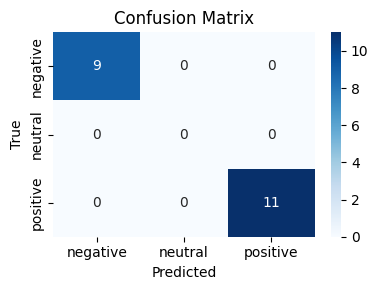

In [13]:
#cell9Confusion Matrix & Classification Report
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions on validation set
pred = trainer.predict(val_tok)
y_true = pred.label_ids
y_pred = pred.predictions.argmax(-1)

# Define the full class set and names
labels_all = [0, 1, 2]
target_names_all = [id2label[i] for i in labels_all]

# Confusion matrix using all labels (will show zero row/col for missing classes)
cm = confusion_matrix(y_true, y_pred, labels=labels_all)
print("Confusion matrix (rows=true, cols=pred):\n", cm)

# Classification report for all 3 classes; missing classes get zero support
print("\nClassification report (all classes; zero_division=0):\n")
print(classification_report(
    y_true,
    y_pred,
    labels=labels_all,
    target_names=target_names_all,
    zero_division=0,
    digits=4
))

# Also show which classes actually appeared in y_true/y_pred
present = sorted(list(set(y_true.tolist()) | set(y_pred.tolist())))
print("Classes present in this validation set:", [id2label[i] for i in present])

# Pretty plot
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names_all,
            yticklabels=target_names_all)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [14]:
#Cell10Sample Predictions,Misclassifications
import random

val_texts = val_df.reset_index(drop=True)["Text"].tolist()
val_true_names = [id2label[i] for i in y_true]
val_pred_names = [id2label[i] for i in y_pred]

n_samples = min(15, len(val_texts))
idxs = random.sample(range(len(val_texts)), k=n_samples)

print(f"Sample predictions ({n_samples}):\n")
for i in idxs:
    txt = val_texts[i]
    print(f"- True: {val_true_names[i]} | Pred: {val_pred_names[i]}")
    print(f"  Text: {txt[:300]}{'...' if len(txt)>300 else ''}\n")

mis = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
print(f"\nTotal misclassified: {len(mis)}")
for i in mis[:3]:
    txt = val_texts[i]
    print(f"[MISCLASSIFIED] True={val_true_names[i]} Pred={val_pred_names[i]}")
    print(f"Text: {txt[:400]}{'...' if len(txt)>400 else ''}\n")

Sample predictions (15):

- True: positive | Pred: positive
  Text: I can't stop listening to this song. It's my new favorite!

- True: positive | Pred: positive
  Text: I'm captivated by this band's unique sound. They're a breath of fresh air!

- True: positive | Pred: positive
  Text: This book made me feel inspired. Highly recommended!

- True: negative | Pred: negative
  Text: The product I received was damaged. Unacceptable.

- True: negative | Pred: negative
  Text: I had a terrible experience with their delivery service. Late and unprofessional.

- True: positive | Pred: positive
  Text: The roller coaster ride was exhilarating! Pure adrenaline rush!

- True: positive | Pred: positive
  Text: The hotel stay was absolutely amazing! Luxury at its finest.

- True: positive | Pred: positive
  Text: This movie is amazing!

- True: negative | Pred: negative
  Text: The customer service at this hotel was terrible. Avoid at all costs.

- True: negative | Pred: negative
  Text: The quali

In [15]:
#Cell 11Save Best Model & Tokenizer
save_dir = os.path.join(OUTPUT_DIR, "best_model")
trainer.save_model(save_dir)        # saves model + config
tokenizer.save_pretrained(save_dir) # saves tokenizer files
print("Saved model and tokenizer to:", save_dir)

# List saved files
!ls -lh {save_dir}

Saved model and tokenizer to: /kaggle/working/sentiment_outputs/best_model
total 419M
-rw-r--r-- 1 root root  839 Nov 10 22:13 config.json
-rw-r--r-- 1 root root 418M Nov 10 22:13 model.safetensors
-rw-r--r-- 1 root root  125 Nov 10 22:13 special_tokens_map.json
-rw-r--r-- 1 root root 1.2K Nov 10 22:13 tokenizer_config.json
-rw-r--r-- 1 root root 695K Nov 10 22:13 tokenizer.json
-rw-r--r-- 1 root root 5.4K Nov 10 22:13 training_args.bin
-rw-r--r-- 1 root root 227K Nov 10 22:13 vocab.txt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
#cell12Inference Utility (Predict on New Texts)
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def predict_texts(texts, model_dir, max_length=MAX_LENGTH):
    tok = AutoTokenizer.from_pretrained(model_dir)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_dir)
    mdl.eval()
    enc = tok(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        out = mdl(**enc)
    probs = out.logits.softmax(-1).numpy()
    id2label_local = mdl.config.id2label
    results = []
    for i, t in enumerate(texts):
        pred_id = int(probs[i].argmax())
        results.append({
            "text": t,
            "prediction": id2label_local[pred_id],
            "probs": {id2label_local[j]: float(probs[i][j]) for j in range(probs.shape[1])}
        })
    return results

sample_inputs = [
    "The product quality is outstanding and I love it!",
    "It was okay, not great but not terrible.",
    "Really disappointed with the service, would not recommend.",
]

inference_results = predict_texts(sample_inputs, save_dir)
for r in inference_results:
    print(r)

{'text': 'The product quality is outstanding and I love it!', 'prediction': 'positive', 'probs': {'negative': 0.19026805460453033, 'neutral': 0.30545714497566223, 'positive': 0.5042747855186462}}
{'text': 'It was okay, not great but not terrible.', 'prediction': 'negative', 'probs': {'negative': 0.42710641026496887, 'neutral': 0.25546687841415405, 'positive': 0.31742674112319946}}
{'text': 'Really disappointed with the service, would not recommend.', 'prediction': 'negative', 'probs': {'negative': 0.4852433204650879, 'neutral': 0.2478560209274292, 'positive': 0.2669007182121277}}


In [17]:
#cell13Export Metrics & Samples for Report
import json
# Store evaluation metrics
with open(os.path.join(OUTPUT_DIR, "eval_metrics.json"), "w") as f:
    json.dump(eval_result, f, indent=2)

# Store a subset of validation predictions
sample_records = []
limit = min(200, len(val_texts))
for i in range(limit):
    sample_records.append({
        "text": val_texts[i],
        "true": val_true_names[i],
        "pred": val_pred_names[i]
    })

with open(os.path.join(OUTPUT_DIR, "sample_predictions.json"), "w") as f:
    json.dump(sample_records, f, indent=2)

print("Saved eval_metrics.json and sample_predictions.json in", OUTPUT_DIR)
!ls -lh {OUTPUT_DIR}

Saved eval_metrics.json and sample_predictions.json in /kaggle/working/sentiment_outputs
total 16K
drwxr-xr-x 2 root root 4.0K Nov 10 22:13 best_model
drwxr-xr-x 4 root root 4.0K Nov 10 22:13 checkpoints
-rw-r--r-- 1 root root  227 Nov 10 22:14 eval_metrics.json
-rw-r--r-- 1 root root 2.6K Nov 10 22:14 sample_predictions.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
!pip -q install --upgrade gradio

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [24]:
# Install Gradio (safe to re-run)
!pip -q install --upgrade gradio

import os, torch, pandas as pd, gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Silence tokenizer parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Path to your saved model from Cell 11
MODEL_DIR = "/kaggle/working/sentiment_outputs/best_model"
MAX_LENGTH = 256

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model + tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(device).eval()

# Labels in order 0..num_labels-1
num_labels = model.config.num_labels
id2label = model.config.id2label
label_order = [id2label[i] for i in range(num_labels)]

def predict_single(text: str):
    """Predict sentiment for a single text. Returns (Label component dict, JSON)."""
    if not isinstance(text, str) or not text.strip():
        return {"": 0.0}, {"error": "Empty input", "prediction": None, "probs": {}}

    enc = tokenizer([text], padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1)[0].detach().cpu().numpy()

    conf_map = {label_order[i]: float(probs[i]) for i in range(num_labels)}
    result_json = {
        "text": text,
        "prediction": max(conf_map, key=conf_map.get),
        "probs": conf_map
    }
    return conf_map, result_json

def predict_csv(file_obj):
    """
    Batch predict for a CSV. Expects a 'Text' column (case-insensitive handled).
    Returns a dataframe: Text, prediction, prob_<label>...
    """
    if file_obj is None:
        return pd.DataFrame([{"error": "No file uploaded"}])

    df = pd.read_csv(file_obj.name)
    df.columns = df.columns.str.strip()

    # Normalize to 'Text' if a common alternative exists
    if "Text" not in df.columns:
        candidates = [c for c in df.columns if c.lower() in {"text", "review", "feedback", "comment", "sentence"}]
        if candidates:
            df = df.rename(columns={candidates[0]: "Text"})
        else:
            return pd.DataFrame([{"error": "CSV must contain a 'Text' column."}])

    texts = df["Text"].astype(str).fillna("").tolist()
    if len(texts) == 0:
        return pd.DataFrame([{"error": "No rows found in 'Text' column."}])

    # Batch tokenize for speed
    enc = tokenizer(texts, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()

    preds = probs.argmax(axis=1)
    pred_labels = [id2label[int(i)] for i in preds]

    out_df = pd.DataFrame({"Text": texts, "prediction": pred_labels})
    for i, label in enumerate(label_order):
        out_df[f"prob_{label}"] = probs[:, i]

    return out_df

# Build Gradio UI
demo = gr.Blocks(title="BERT Sentiment Classifier")
with demo:
    gr.Markdown("# BERT Sentiment Classifier\nEnter text or upload a CSV with a 'Text' column.")
    with gr.Tabs():
        with gr.Tab("Single Text"):
            inp = gr.Textbox(lines=4, label="Enter customer feedback")
            btn = gr.Button("Predict")
            out_label = gr.Label(num_top_classes=len(label_order), label="Prediction (confidence)")
            out_json = gr.JSON(label="Raw output")
            examples = gr.Examples(
                examples=[
                    "I absolutely love this product! Exceeded my expectations.",
                    "It was okay, nothing special.",
                    "Very disappointed. The service was terrible."
                ],
                inputs=inp
            )
            btn.click(fn=predict_single, inputs=inp, outputs=[out_label, out_json])

        with gr.Tab("Batch CSV"):
            file_in = gr.File(file_count="single", file_types=[".csv"], label="Upload CSV with a 'Text' column")
            btn2 = gr.Button("Run batch prediction")
            out_df = gr.Dataframe(label="Results", wrap=True)
            btn2.click(fn=predict_csv, inputs=file_in, outputs=out_df)

# IMPORTANT for Kaggle: use share=True (Internet must be ON). Click the public link printed below.
# If you prefer inline and it works in your session, change inline=True and share=False.
gr.close_all()  # ensure no previous server is running
demo.queue().launch(
    share=True,              # creates a public gradio.live link
    server_name="0.0.0.0",
    server_port=7860,
    inline=False,            # rely on the public link instead of 127.0.0.1
    show_error=True
)

Closing server running on port: 7861
Closing server running on port: 7860
* Running on local URL:  http://0.0.0.0:7860
* Running on public URL: https://a2bafb64859a8a10cb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
